# Importing Packages

In [1]:
import random
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

import cv2

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.layers import Dense, Conv2D, Flatten, Dropout, AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

## Constants

In [2]:
os.chdir("./..")
REPO_PATH = os.getcwd().replace("\\" , "/")
DATA_PATH = f"{REPO_PATH}/data"
MODEL_CHECKPOINTS_PATH = f"{REPO_PATH}/model_checkpoints"
LABELS = {0: "Carrying", 1: "Normal", 2: "Threat"}
image_length = 256

## Functions

In [3]:
# For Visualization of images and labels
def plot_images(image_array):
    """
    Plots images in a grid of 5 columns
    """
    num_images_per_row = 5
    num_images = len(image_array)
    num_rows = num_images // num_images_per_row
    if num_rows * 5 < num_images: num_rows += 1
    fig, axes = plt.subplots(num_rows, num_images_per_row)
    axes = axes.flatten()
    for img, ax in zip(image_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def print_label(labels):
    """
    Prints the label of the image
    """
    if labels.shape == (3,):
        print(LABELS[np.where(labels == 1)[0][0]])
        return
    for label in labels:
        print(LABELS[np.where(label == 1)[0][0]])

In [4]:
def add_noise(filepath_or_image, noise_coefficient, noise_type = "pepper", seed = 4243):
    """
    Parameters:
    filepath_or_image: string, filepath of an image. OR, 2-Dimensional numpy array, image
    noise_coefficient: float, a number nc from 0 to 1. function will fill (nc*100)% of the image with noise
    noise_type = "pepper": string, "salt" or "pepper"
    seed = 1: int, set the random seed for the randomizer
    
    Function will output an image with (nc*100)% of noise specified.
    """
    if type(filepath_or_image) == str:
        image = cv2.imread(filepath_or_image)
    else:
        image = np.copy(filepath_or_image)
    image_dimensions = image.shape
    num_pixels = image_dimensions[0] * image_dimensions[1]
    random.seed(seed)
    noise = random.sample(range(0, num_pixels), int(num_pixels * noise_coefficient))
    noise_pixel_intensity = 255 if noise_type == "salt" else 0
    for pixel in noise:
        x = pixel // image_dimensions[1] # pixel position on the x-axis
        y = (pixel % image_dimensions[1]) - 1 # pixel position on the y-axis
        for i in [0, 1, 2]:
            image[x][y][i] = noise_pixel_intensity
    return image

def add_blur_default(image, ksize = (5,5)):
    """
    Takes in an image and returns an image with blur. 
    ksize is the kernel size for the Gaussian Blur
    seed is for the generation of Standard Deviation used for Gaussian Blur. Default is 0
    Standard Deviation is normally distributed from the uniform distribution U(0,0.2)
    """
    sd = random.uniform(0, 0.3)
    blurred = cv2.GaussianBlur(image, ksize, sd)
    return blurred

def add_noise_default(image, seed = 4243):
    """
    Takes in an image and returns an image with pepper noise. 
    Noise coefficient is randomly drawn from the uniform distribution, U(0, 0.2)
    Noise Type is randomly selected from salt or pepper
    """
    noise_coefficient = random.uniform(0,0.2)
    noise_type = random.choice(["pepper", "salt"])
    img = add_noise(image, noise_coefficient, noise_type = noise_type, seed = seed)
    return img

def add_noise_and_blur_default(image, seed = 4243):
    """
    Takes in an image and returns an image with pepper noise. 
    Noise coefficient is randomly drawn from the uniform distribution, U(0, 0.2)
    Noise Type is randomly selected from salt or pepper
    """
    noise_coefficient = random.uniform(0,0.2)
    noise_type = random.choice(["pepper", "salt"])
    img = add_blur_default(image)
    img = add_noise(img, noise_coefficient, noise_type = noise_type, seed = seed)
    return img

## Reading in Dataset to Flow

In [5]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_path = f"{DATA_PATH}/train/"
val_path = f"{DATA_PATH}/val/"
test_path = f"{DATA_PATH}/test/"
batch_size = 32
image_size = (image_length, image_length)

train_datagen = ImageDataGenerator(rescale =1./255, preprocessing_function=add_noise_and_blur_default,
                                   horizontal_flip = True,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 15,
                                   zoom_range = 0.1,
                                   fill_mode='reflect')
test_datagen = ImageDataGenerator(rescale = 1./255)


train_batches = train_datagen.flow_from_directory(
    train_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = 'rgb',
    shuffle = True,
)

validation_batches = test_datagen.flow_from_directory(
    val_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = 'rgb',
    shuffle = True,
)

test_batches = test_datagen.flow_from_directory(
    test_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = "categorical",
    color_mode = 'rgb',
    shuffle = True,
)

Found 4320 images belonging to 3 classes.
Found 540 images belonging to 3 classes.
Found 497 images belonging to 3 classes.


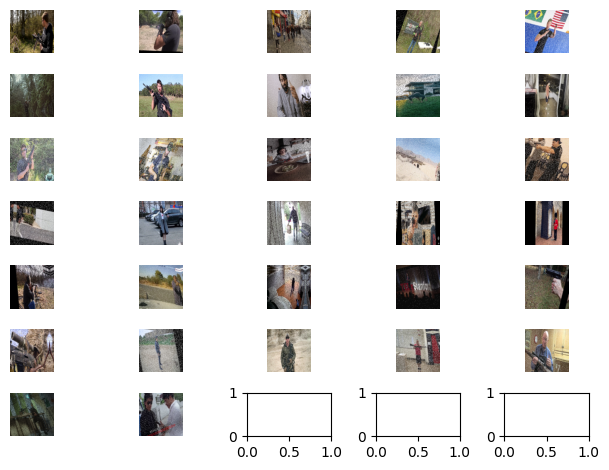

In [6]:
images, labels = train_batches[0]
images
plot_images(images)

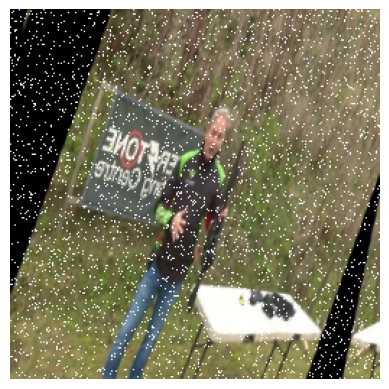

In [7]:
image_index = 3
plt.imshow(images[image_index])
plt.axis("off")
plt.show()

## Model

In [8]:
# Create a  model
def create_model():
    model = keras.Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(image_length, image_length, 3)))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=3, activation = 'softmax'))


    return model

In [9]:
model = create_model()

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy', metrics.categorical_accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 127, 127, 16)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 62, 62, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 average_pooling2d_2 (Averag  (None, 30, 30, 32)       0

In [10]:
max_epochs = 300
patience = 5

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=patience),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'{MODEL_CHECKPOINTS_PATH}/lenet_enhanced_rgb_aug.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(
        train_batches,
        steps_per_epoch = train_batches.__len__(),
        epochs = max_epochs,
        workers = 8,
        validation_data = validation_batches,
        validation_steps = validation_batches.__len__(),
        shuffle = True,
        callbacks=my_callbacks
)

Epoch 1/300
135/135 [==============================] - 61s 435ms/step - loss: 1.0944 - accuracy: 0.3678 - categorical_accuracy: 0.3678 - val_loss: 1.0794 - val_accuracy: 0.4185 - val_categorical_accuracy: 0.4185
Epoch 2/300
135/135 [==============================] - 60s 429ms/step - loss: 1.0738 - accuracy: 0.4208 - categorical_accuracy: 0.4208 - val_loss: 1.0564 - val_accuracy: 0.4574 - val_categorical_accuracy: 0.4574
Epoch 3/300
135/135 [==============================] - 60s 434ms/step - loss: 1.0575 - accuracy: 0.4248 - categorical_accuracy: 0.4248 - val_loss: 1.0432 - val_accuracy: 0.4796 - val_categorical_accuracy: 0.4796
Epoch 4/300
135/135 [==============================] - 60s 432ms/step - loss: 1.0413 - accuracy: 0.4632 - categorical_accuracy: 0.4632 - val_loss: 1.0528 - val_accuracy: 0.4185 - val_categorical_accuracy: 0.4185
Epoch 5/300
135/135 [==============================] - 61s 440ms/step - loss: 1.0223 - accuracy: 0.4787 - categorical_accuracy: 0.4787 - val_loss: 1.034

## Testing

In [11]:
all_images = []
# Get y_test
y_test = []
for batch_num in range(test_batches.__len__()):
    images, labels = test_batches[batch_num]
    y_test.extend(labels)
    all_images.extend(images)
    
y_test = np.array(y_test)
y_tested_labels = [np.argmax(y_test[i]) for i in range(len(y_test))]

In [12]:
# Get y_prediction
y_prediction = model.predict(test_batches)
y_predicted_labels = [np.argmax(y_prediction[i]) for i in range(len(y_prediction))]

16/16 [==============================] - 11s 673ms/step


In [13]:
print(y_tested_labels[:10])
print(y_predicted_labels[:10])

[0, 0, 0, 1, 2, 1, 2, 2, 1, 1]
[1, 0, 0, 1, 2, 1, 2, 1, 1, 1]


In [14]:
test_acc = accuracy_score(y_tested_labels, y_predicted_labels)

recall_macro =  recall_score(y_tested_labels, y_predicted_labels, average='macro')
recall_micro = recall_score(y_tested_labels, y_predicted_labels, average='micro')
recall_weighted = recall_score(y_tested_labels, y_predicted_labels, average='weighted')

print(f"test_acc: {test_acc}")
print(f"recall_macro: {recall_macro}")
print(f"recall_micro: {recall_micro}")
print(f"recall_weighted: {recall_weighted}")


test_acc: 0.8108651911468813
recall_macro: 0.8096512570965126
recall_micro: 0.8108651911468813
recall_weighted: 0.8108651911468813


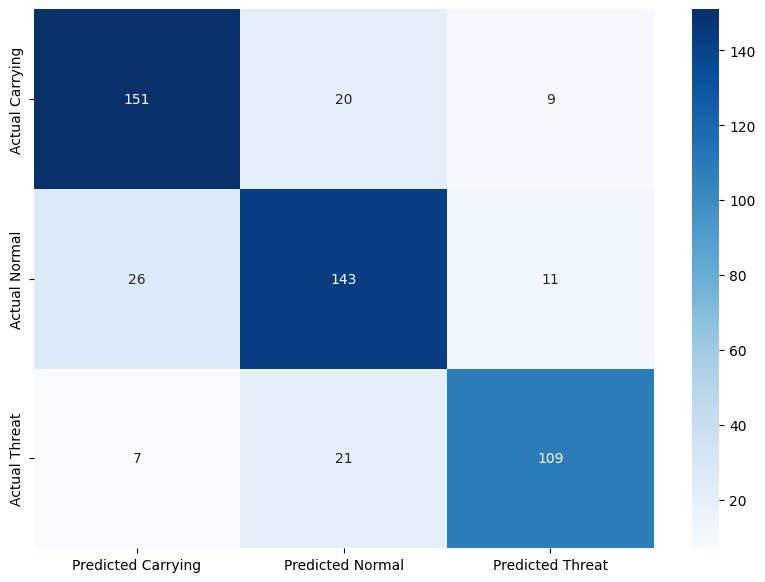

In [15]:
# Create confusion matrix
result = confusion_matrix(y_tested_labels, y_predicted_labels)
cf_matrix = pd.DataFrame(result, 
                                columns = ["Predicted Carrying", "Predicted Normal", "Predicted Threat"], 
                                index = ["Actual Carrying", "Actual Normal", "Actual Threat"])
plt.figure(figsize = (10,7))
sn.heatmap(cf_matrix, 
           annot=True, 
           cmap='Blues', 
           fmt='.3g')
plt.show()

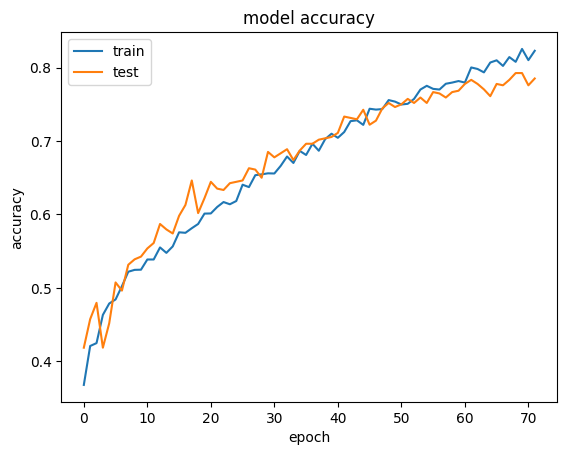

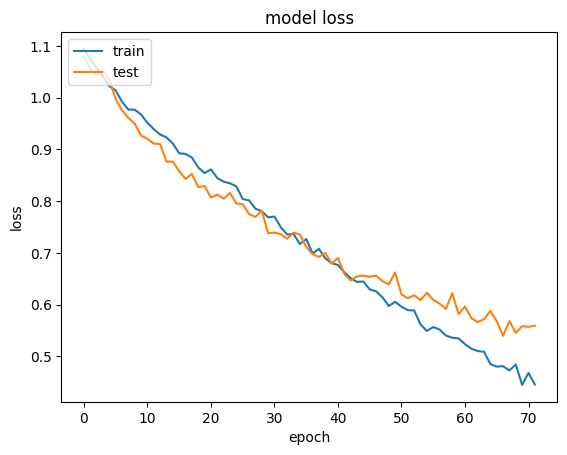

In [16]:
# summarize history for accuracy
history = history.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()